
# PART-3 : Deep Learning Classifier for The Human Freedom Index

<div class="alert alert-success">

The <a href="https://www.cato.org/human-freedom-index/2021 ">Human Freedom Index</a> measures economic freedoms such as the freedom to trade or to use sound money, and it captures the degree to which people are free to enjoy the major freedoms often referred to as civil liberties—freedom of speech, religion, association, and assembly— in the countries in the survey. In addition, it includes indicators on rule of law, crime and violence, freedom of movement, and legal discrimination against same-sex relationships. We also include nine variables pertaining to women-specific freedoms that are found in various categories of the index.

<u>Citation</u>

Ian Vásquez, Fred McMahon, Ryan Murphy, and Guillermina Sutter Schneider, The Human Freedom Index 2021: A Global Measurement of Personal, Civil, and Economic Freedom (Washington: Cato Institute and the Fraser Institute, 2021).

In [1]:
import pandas as pd
import numpy as np

<div class="alert alert-info"></b>

Loading the Human Freedom Index data ```df```.

The data is laoded from the following URL https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv 



<div class='alert alert-warning'>
    
The following columns are redundant and should be dropped:
* ```year```
* ```ISO```
* ```countries```
* All columns containing the word ```rank``` 
* All columns containing the word ```score```
    
</div>


### Setting up feature matrix (X) and target array (y)
We follow the below mentioned steps in order to get X & y : 
* Loading the data into a dataframe ```df```
* Removed ```year```,```ISO``` & ```countries``` columns from ```df```
* Checked if the columns contained ```rank``` or ```score``` key word and removed all the features containing either of the key words
* Checked if the target feature had any **NA** values, and we observed that there were indeed **113** rows in ```df``` where ```hf_quartile``` was NA. Hence, we removed all the rows where ```hf_quartile``` was missing. 
* After checking & removing the missing values in target variable, we split ```df``` and stored the independent variables and target variable in ```X``` & ```y``` respectively.

### Splitting the feature matrix (X) & target array (y)
After obtaining feature matrix ```X``` & target variable ```y```, we split the data into training & test sets with relative size of **0.75 & 0.25 respectively**. We used sklearn's  **```train_test_split```** module to perform this operation.

In [6]:
#loading HFI data to a dataframe
df=pd.read_csv('https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv')

#Deleting redundant features 
df = df.drop(['year', 'ISO', 'countries'], axis=1)

cols = list(df.columns)

del_cols=[]
for col in cols : 
    if ("rank" in col) | ("score" in col) : 
        del_cols.append(col)

#Deleting redundant features        
df=df.drop(del_cols, axis=1)

#Checking for NA values in the target variable
print("Checking for NA values in hf_quartile")
print(df.isna().sum(), "\n\n")

#Dropping the rows where the target variable is NA
df=df[df['hf_quartile'].notna()]

print("Checking for NA values after addressing them in the target variable")
print(df.isna().sum())

#Storing the independent variables in X and target variable in y
X=df.drop('hf_quartile', axis=1)
y=df['hf_quartile']

#Splitting the feature matrix and the target variable 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

Checking for NA values in hf_quartile
region                                 0
hf_quartile                          113
pf_rol_procedural                    731
pf_rol_civil                         731
pf_rol_criminal                      731
                                    ... 
ef_regulation_business_bribes         69
ef_regulation_business_licensing     144
ef_regulation_business_compliance    127
ef_regulation_business               117
ef_regulation                        100
Length: 114, dtype: int64 


Checking for NA values after addressing them in the target variable
region                                 0
hf_quartile                            0
pf_rol_procedural                    636
pf_rol_civil                         636
pf_rol_criminal                      636
                                    ... 
ef_regulation_business_bribes         34
ef_regulation_business_licensing      31
ef_regulation_business_compliance     14
ef_regulation_business                 4
ef_r

### Setting up the pipeline for ML lifecycle
We followed the below mentioned steps in order to create a pipeline. This pipeline automates the data preprocessing, normalization and model selection part of the Machine learning lifecycle : 
* We imported all the necessary classes from the ```sklearn``` library.
* We stored the numerical and categorical features in the feature matrix ```X``` into 2 separate lists called ```numerical_features``` & ```categorical_features``` respectively. 
* The only preprocessing needed for numerical features is imputation of NAs. So we instantiated the ```SimpleImputer()``` class while using the ```most_frequent``` strategy for the imputation.
* The only preprocessing needed for categorical features is Onehot econding. So we instantiated the ```OneHotEncoder()``` class for encoding. 
* We created a Column transformer object called ```transformer``` that does the above mentioned preprocessing steps for both numerical and categorical variables. 
* As a final step, we created a **Pipeline** with the following steps **in order** : 
    * Step-1 : Data preprocessing using ```transformer```
    * Step-2 : Data normalization using ```StandardScaler()```
    * Step-3 : Training an ML model (```MLPClassifier(max_iter=250))```)

In [7]:
#Importing necessary modules
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


#Storing the column names of numerical & categorical features in different lists 
numerical_features = list(X.select_dtypes(exclude='object').columns)
categorical_feature = ['region']


#Building the column transformer
imp_num = SimpleImputer(strategy='most_frequent')
enc_cat = OneHotEncoder(sparse=False)

#Building the column transformer
transformer = ColumnTransformer([('num_features', imp_num, numerical_features),
                                 ('cat_features', enc_cat, categorical_feature)],
                                   remainder='passthrough')


#Setting up the final pipeline
steps = [('preprocessing', transformer),
        ('normalization', StandardScaler()),
        ('training', MLPClassifier(max_iter=250))]

pipe = Pipeline(steps)
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_features',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['pf_rol_procedural',
                                                   'pf_rol_civil',
                                                   'pf_rol_criminal', 'pf_rol',
                                                   'pf_ss_homicide',
                                                   'pf_ss_disappearances_disap',
                                                   'pf_ss_disappearances_violent',
                                                   'pf_ss_disappearances_organized',
                                                   'pf_ss_disappearances_fatalities...
                                                   'pf_religion_freedom_vdem',
                                              

### Performing a Grid Search to find optimal hyperparameters of the MLPClassifier

In this part, we instantiate the **```GridSearchCV```** class. The ```pipe``` that was created in the previous exercise is used and we only optimize the Multi-layer perceptron Classifier's hyperparameters.

For fitting the grid, we used **```X_train```** & **```y_train```** that we previously otained.

As a last step, we displayed the accuracy of the model of the training phase & stored it in a variable called **```training_score```**.

In [8]:
# YOUR CODE HERE

#Importing warnings library in order to filter out all the warnings.
import warnings
warnings.filterwarnings('ignore')

#Setting up the grid search dictionary with the required hyperparameters
param_grid = { 
'training__learning_rate_init' : [0.001, 0.0001],
'training__alpha' : [0.0001,1]
} 

#Importing the GridSearchCV module 
#Using the pipe from the previous exercise, fitting the grid with 5 folds & optimizing of the ML model
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid, verbose=1)
grid.fit(X_train, y_train)

#Displaying the best hyperparameters of the Logistic Regression model
print("The optimal hyperparameters for this GridSearch are : \n ")
print(grid.best_params_)

#Storing the training phase score of the best estimator in a variable called score
score = grid.best_estimator_.score(X_train, y_train)
print("\n THE ACCURACY OF THIS MODEL ON THE TRAINING SET IS : ", round(score,4))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The optimal hyperparameters for this GridSearch are : 
 
{'training__alpha': 0.0001, 'training__learning_rate_init': 0.001}

 THE ACCURACY OF THIS MODEL ON THE TRAINING SET IS :  1.0


Now we check the accuracy of the network on the test set to check for overfititng. 

In [10]:
# YOUR CODE HERE
score = grid.best_estimator_.score(X_test, y_test)
print("\n THE ACCURACY OF THIS MODEL ON THE TEST SET IS : ", round(score,4))


 THE ACCURACY OF THIS MODEL ON THE TEST SET IS :  0.9379


#### THE MODEL IS INDEED OVERFITTED!!

# Turning to KERAS

## Train-Validation split

We take the feature matrix **``X``** & target variable **``y``** and split them into training and validation sets. 
**``X_train``** & **``y_train``** will be used to train the neural network, whereas **``X_test``** & **``y_test``** will act as validation sets to test the final neural network. 

For this exercise, we perform a **80%-20%** split

We use scikitlearn's **``train_test_split``** module to perform this operation.
As a final step, we also set the **``random_state parameter``** to ensure reproducibility of results. 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=11)

## The Neural Network Architecture 

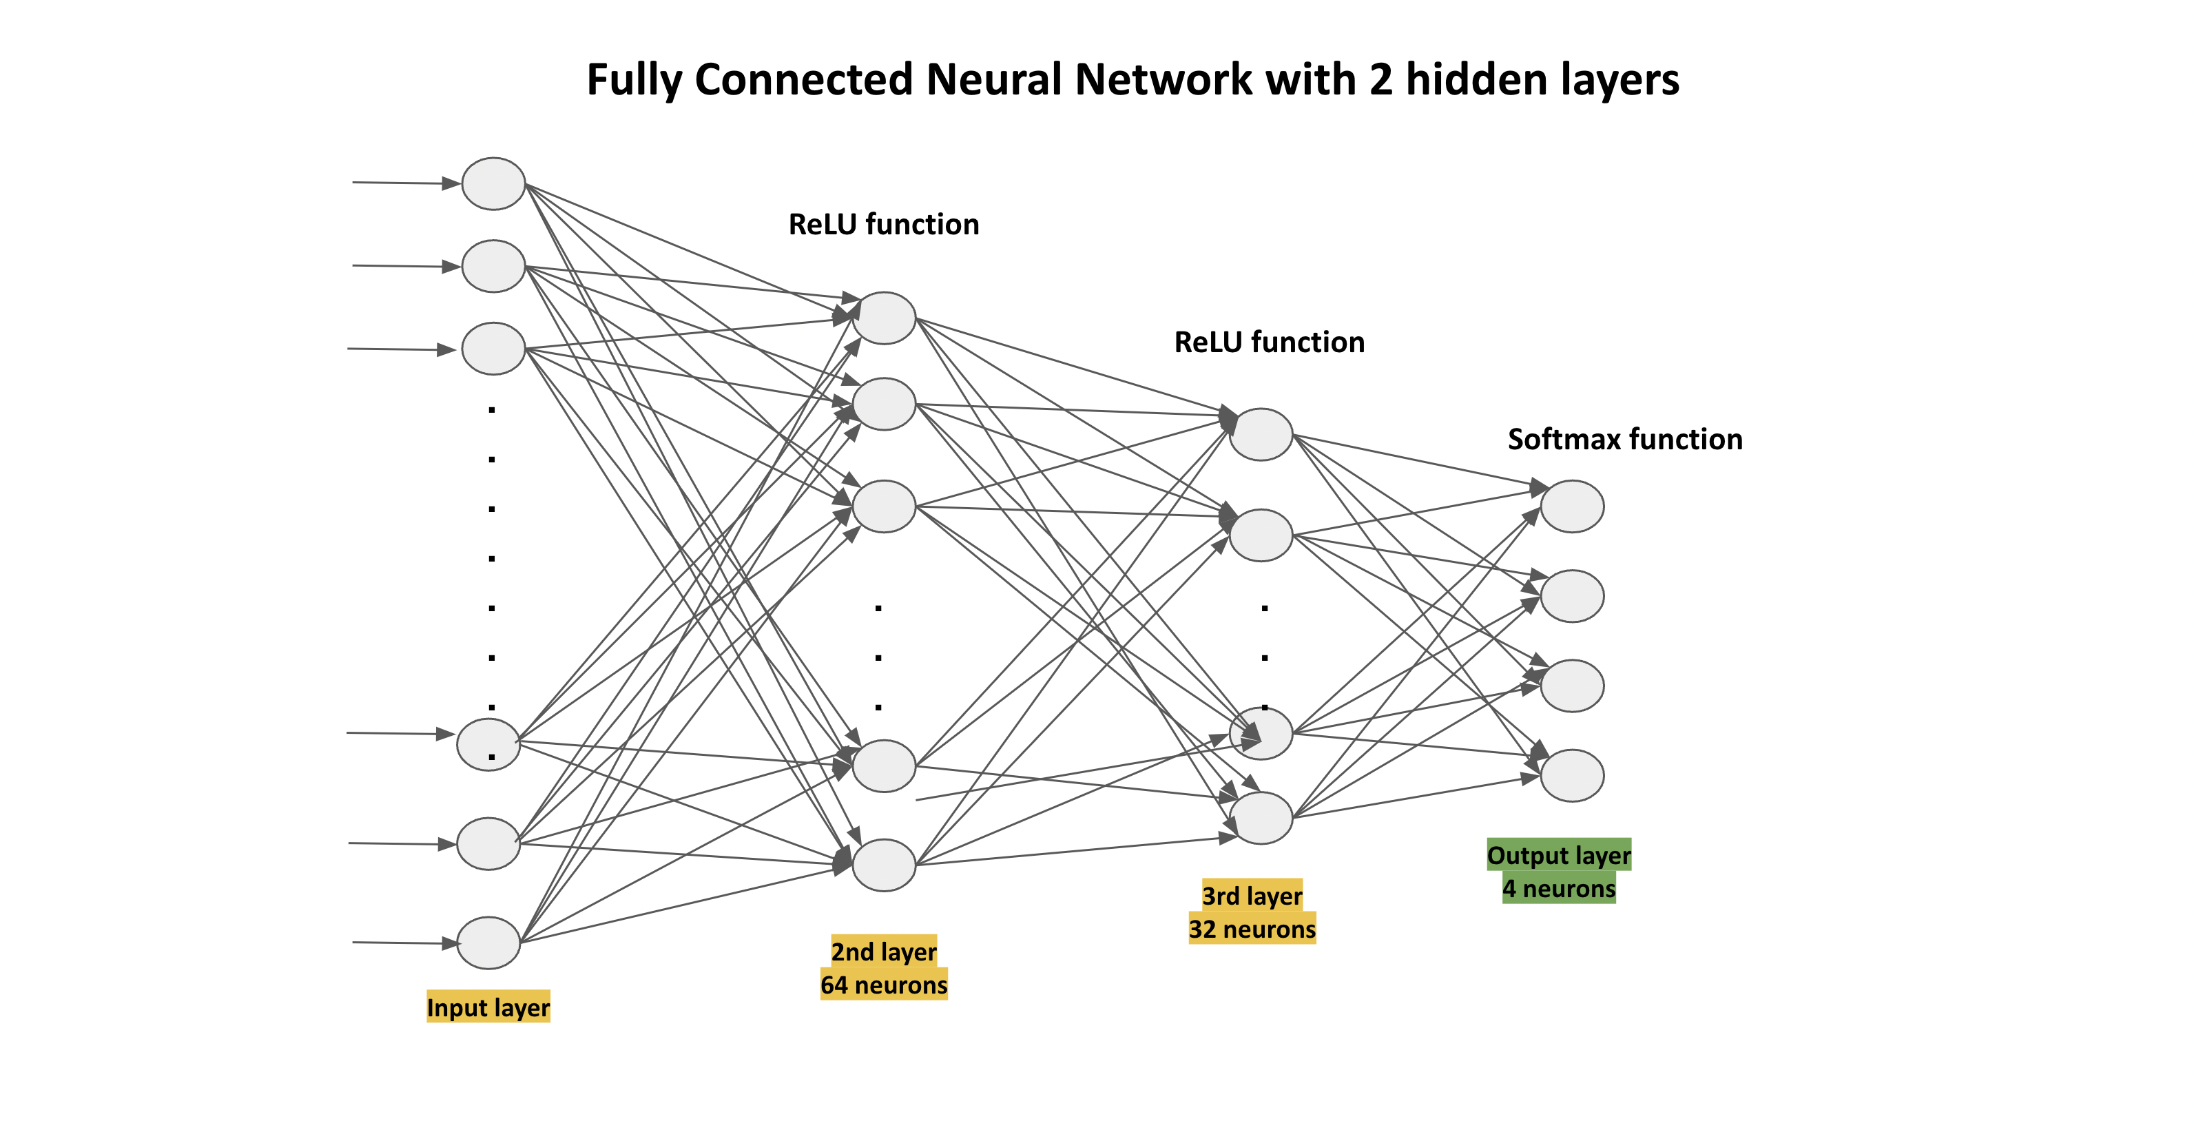

We are performing the preprocessing steps for this exercise using scikitlearn itself as it is much easier to perform all the required preprocessing steps using **sklearn's pipeline**.

## The ```custom_pipe``` function

As mentioned above, we have created a function called **```custom_pipe()```** that takes the following necessary parameters :
* **```X```** - The feature matrix
* **```y```** - The target variable
* **```model```** - A sklearn wrapper that depends on the choice of the ML model

The function returns an sklearn's **pipe** object. 

The preprocessing steps involved in this custom pipe function are **same as those in Exercise-2**.

In [15]:
def custom_pipe(X, y, model):
    #Storing the column names of numerical & categorical features in different lists 
    numerical_features = list(X.select_dtypes(exclude='object').columns)
    categorical_feature = ['region']
    
    #Building the column transformer
    imp_num = SimpleImputer(strategy='most_frequent')
    enc_cat = OneHotEncoder(sparse=False)
    transformer = ColumnTransformer([('num_features', imp_num, numerical_features),
                                     ('cat_features', enc_cat, categorical_feature)],
                                       remainder='passthrough')
    #Setting up the final pipeline
    steps = [('preprocessing', transformer),
            ('normalization', StandardScaler()),
            ('training', model)]

    pipe = Pipeline(steps)
    
    return pipe

The neural network model that we use in this exercise comes from the **Keras** library. Instead of directly using a **Sequential** model to train the neural network, we adapt the model into sklearn's pipeline by first building the neural network using the Keras library and then using the **```KerasClassifier```** wrapper of the sklearn library so that we are able to adapt this neural network in our sklearn pipeline. 

## The ```architecture``` function

This function builds the neural network using the **Keras** library and returns a model that can be later used to adapt into sklearn's pipeline. The function takes the following arguments : 

* **```n_layers```** - int : The number of hidden layers (including the output layer)
* **```n_neurons```** - list : Number of neurons in each layer 
* **```dropout```** - float : Randomly drops out (sets to zero) a specified fraction of the input units during each training iteration. This helps in avoiding overfitting
* **```loss```** - str: Specifies the loss function that the model should optimize during training the network. 
* **```optimizer```** - str : Specifies the optimization algorithm that the model uses to update its weights during training.


We instantiate the **```Sequential```** module from the Keras library to setup the network. We then **add** hidden layers to our network using the **```Dense```** module and set the regularizarion using the **```Dropout```** module. 

<div class="alert alert-warning">
In the Keras setting, it is important to note that the number of neurons in the output layer must always be equal to the number of classes in the target variable. 
</div>

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def architecture(n_layers, n_neurons, dropout, loss, optimizer):
    #Setting up the netowrk 
    
    model = Sequential()
    for layer in range(n_layers-1):
        model.add(Dense(n_neurons[layer], activation='relu'))    #Adding hidden layers 
        model.add(Dropout(dropout))                              #Adding regularization parameter
    
    #Adding the output layer with 4 neurons (because the target variable contains 4 classes)
    model.add(Dense(4, activation='softmax'))
    
    #Setting up the loss function, optimizer and metrics for the network
    model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
    
    return model

## Training the network 

As a next step, we train the neural network by adapting the Keras model into scikitlearn pipeline. 
We try out various combinations of **loss functions** and **optimizers** in this step. 

We also add a dropout of **0.1** for each hidden layer and for every variation.

In [17]:
#Defining a vector v which will be a parameter to the architecture function
#v is defined according to our network architecture diagram. 
v = [64, 32, 4]

loss_funcs = ['squared_hinge', 'hinge', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
optimizers = ['sgd', 'adam', 'adagrad', 'rmsprop']

In [18]:
#Defining empty lists which will be used in creating a dataframe in the next step
los = []
opt = []
train_scores = []
test_scores = []

for loss in loss_funcs:
    for optimizer in optimizers: 
        los.append(loss)
        opt.append(optimizer)
        
        #Setting up the scikit learn keras wrapper 
        model = KerasClassifier(build_fn= lambda : architecture(len(v),v,0.1, loss, optimizer), verbose=0)
        
        #Setting up the pipeline 
        pipe = custom_pipe(X_train, y_train, model)
        
        #Fitting the pipeline
        pipe.fit(X_train, y_train)
        
        #Storing training and test scores
        train_scores.append(pipe.score(X_train, y_train))
        test_scores.append(pipe.score(X_test, y_test))

2023-02-26 23:51:46.805103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Lets create a dataframe to store the scores for all the possible combinations and sort the dataframe in **decreasing order of Test score**

In [19]:
#Creating a dictionary
dic={"Loss Function":los,
    "Optimizer":opt,
    "Training Score":train_scores,
    "Test Score":test_scores,
    }

#Storing the data in a dataframe
df=pd.DataFrame(dic)

#Sorting the dataframe in descending order of Test scores.
df = df.sort_values(by='Test Score', ascending=False).reset_index().drop(['index'], axis=1)
df

,Loss Function,Optimizer,Training Score,Test Score
0,categorical_crossentropy,adam,0.835901,0.847594
1,categorical_crossentropy,rmsprop,0.874079,0.847594
2,sparse_categorical_crossentropy,adam,0.840589,0.836898
3,sparse_categorical_crossentropy,rmsprop,0.851306,0.818182
4,sparse_categorical_crossentropy,sgd,0.672472,0.652406
5,categorical_crossentropy,sgd,0.634293,0.612299
6,categorical_crossentropy,adagrad,0.482920,0.500000
7,sparse_categorical_crossentropy,adagrad,0.371065,0.363636
8,hinge,adam,0.350971,0.336898
9,hinge,sgd,0.264568,0.272727


## Performing GridSearch to optimize hyperparameters

Based on the data obtained from the above dataframe, We take the configuration that gives us the best test score and perform a GridSearch to optimize the following hyperparameters : 
- **```epochs```** - int : Specifies the number of times the entire training dataset will be shown to the neural network during training.
- **```batch_size```** - int : Specifies the number of samples used in each iteration of the training process. 

In [20]:
#Importing warnings library in order to filter out all the warnings.
import warnings
warnings.filterwarnings('ignore')

#Setting up the scikit learn keras wrapper 
best_loss_function = df.iloc[0]['Loss Function']
print("The loss function being used is ", best_loss_function)
best_optimizer = df.iloc[0]['Optimizer']
print("The optimizer being used is ", best_optimizer, "\n")
model = KerasClassifier(build_fn= lambda : architecture(len(v), v, 0.5, best_loss_function, best_optimizer))

#Setting up the pipeline 
pipe = custom_pipe(X_train, y_train, model)

#Setting up the grid search dictionary with the required hyperparameters
param_grid = { 
'training__epochs' : [10, 20, 30],
'training__batch_size' : [16, 32, 64]
} 

#Importing the GridSearchCV module 
#Using the pipe from the previous exercise, fitting the grid with 3 folds & optimizing of the ML model
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, verbose=0)
grid.fit(X_train, y_train)

The loss function being used is  categorical_crossentropy
The optimizer being used is  adam 

Epoch 1/10
63/63 [==============================] - 0s 763us/step - loss: 1.3596 - accuracy: 0.4392
Epoch 2/10
63/63 [==============================] - 0s 664us/step - loss: 0.9778 - accuracy: 0.5487
Epoch 3/10
63/63 [==============================] - 0s 649us/step - loss: 0.7960 - accuracy: 0.6543
Epoch 4/10
63/63 [==============================] - 0s 688us/step - loss: 0.7227 - accuracy: 0.6834
Epoch 5/10
63/63 [==============================] - 0s 689us/step - loss: 0.6475 - accuracy: 0.7296
Epoch 6/10
63/63 [==============================] - 0s 679us/step - loss: 0.5630 - accuracy: 0.7628
Epoch 7/10
63/63 [==============================] - 0s 671us/step - loss: 0.5247 - accuracy: 0.7729
Epoch 8/10
63/63 [==============================] - 0s 704us/step - loss: 0.4817 - accuracy: 0.7799
Epoch 9/10
63/63 [==============================] - 0s 747us/step - loss: 0.4306 - accuracy: 0.8281
Epoch 

63/63 [==============================] - 0s 738us/step - loss: 0.5344 - accuracy: 0.7631
Epoch 8/20
63/63 [==============================] - 0s 664us/step - loss: 0.5097 - accuracy: 0.7861
Epoch 9/20
63/63 [==============================] - 0s 685us/step - loss: 0.4400 - accuracy: 0.8183
Epoch 10/20
63/63 [==============================] - 0s 658us/step - loss: 0.4589 - accuracy: 0.8072
Epoch 11/20
63/63 [==============================] - 0s 689us/step - loss: 0.4039 - accuracy: 0.8494
Epoch 12/20
63/63 [==============================] - 0s 682us/step - loss: 0.4077 - accuracy: 0.8373
Epoch 13/20
63/63 [==============================] - 0s 655us/step - loss: 0.3762 - accuracy: 0.8414
Epoch 14/20
63/63 [==============================] - 0s 667us/step - loss: 0.3396 - accuracy: 0.8675
Epoch 15/20
63/63 [==============================] - 0s 684us/step - loss: 0.3366 - accuracy: 0.8755
Epoch 16/20
63/63 [==============================] - 0s 652us/step - loss: 0.3449 - accuracy: 0.8705
Epoc

63/63 [==============================] - 0s 618us/step - loss: 0.6059 - accuracy: 0.7400
Epoch 6/30
63/63 [==============================] - 0s 653us/step - loss: 0.5728 - accuracy: 0.7410
Epoch 7/30
63/63 [==============================] - 0s 626us/step - loss: 0.5163 - accuracy: 0.7821
Epoch 8/30
63/63 [==============================] - 0s 610us/step - loss: 0.4816 - accuracy: 0.8022
Epoch 9/30
63/63 [==============================] - 0s 625us/step - loss: 0.4189 - accuracy: 0.8273
Epoch 10/30
63/63 [==============================] - 0s 605us/step - loss: 0.4251 - accuracy: 0.8203
Epoch 11/30
63/63 [==============================] - 0s 602us/step - loss: 0.4063 - accuracy: 0.8404
Epoch 12/30
63/63 [==============================] - 0s 618us/step - loss: 0.4056 - accuracy: 0.8373
Epoch 13/30
63/63 [==============================] - 0s 620us/step - loss: 0.3365 - accuracy: 0.8705
Epoch 14/30
63/63 [==============================] - 0s 688us/step - loss: 0.3584 - accuracy: 0.8635
Epoch 

32/32 [==============================] - 0s 778us/step - loss: 1.0925 - accuracy: 0.5226
Epoch 3/20
32/32 [==============================] - 0s 777us/step - loss: 0.9467 - accuracy: 0.5829
Epoch 4/20
32/32 [==============================] - 0s 723us/step - loss: 0.8193 - accuracy: 0.6412
Epoch 5/20
32/32 [==============================] - 0s 735us/step - loss: 0.7748 - accuracy: 0.6533
Epoch 6/20
32/32 [==============================] - 0s 751us/step - loss: 0.6969 - accuracy: 0.6975
Epoch 7/20
32/32 [==============================] - 0s 685us/step - loss: 0.6561 - accuracy: 0.7055
Epoch 8/20
32/32 [==============================] - 0s 702us/step - loss: 0.6535 - accuracy: 0.7075
Epoch 9/20
32/32 [==============================] - 0s 724us/step - loss: 0.5842 - accuracy: 0.7437
Epoch 10/20
32/32 [==============================] - 0s 720us/step - loss: 0.5716 - accuracy: 0.7477
Epoch 11/20
32/32 [==============================] - 0s 706us/step - loss: 0.5394 - accuracy: 0.7809
Epoch 12/

Epoch 11/30
32/32 [==============================] - 0s 886us/step - loss: 0.5317 - accuracy: 0.7839
Epoch 12/30
32/32 [==============================] - 0s 865us/step - loss: 0.4626 - accuracy: 0.8101
Epoch 13/30
32/32 [==============================] - 0s 854us/step - loss: 0.4599 - accuracy: 0.8141
Epoch 14/30
32/32 [==============================] - 0s 829us/step - loss: 0.4536 - accuracy: 0.8231
Epoch 15/30
32/32 [==============================] - 0s 814us/step - loss: 0.4147 - accuracy: 0.8342
Epoch 16/30
32/32 [==============================] - 0s 891us/step - loss: 0.4204 - accuracy: 0.8342
Epoch 17/30
32/32 [==============================] - 0s 808us/step - loss: 0.3981 - accuracy: 0.8352
Epoch 18/30
32/32 [==============================] - 0s 1ms/step - loss: 0.3644 - accuracy: 0.8593
Epoch 19/30
32/32 [==============================] - 0s 1ms/step - loss: 0.3549 - accuracy: 0.8623
Epoch 20/30
32/32 [==============================] - 0s 915us/step - loss: 0.3578 - accuracy: 0

16/16 [==============================] - 0s 865us/step - loss: 0.6735 - accuracy: 0.7018
Epoch 10/10
8/8 [==============================] - 0s 691us/step - loss: 0.4508 - accuracy: 0.8431
Epoch 1/20
16/16 [==============================] - 0s 854us/step - loss: 1.6451 - accuracy: 0.3347
Epoch 2/20
16/16 [==============================] - 0s 838us/step - loss: 1.1549 - accuracy: 0.4814
Epoch 3/20
16/16 [==============================] - 0s 843us/step - loss: 0.9648 - accuracy: 0.5849
Epoch 4/20
16/16 [==============================] - 0s 764us/step - loss: 0.8615 - accuracy: 0.6111
Epoch 5/20
16/16 [==============================] - 0s 787us/step - loss: 0.7517 - accuracy: 0.6714
Epoch 6/20
16/16 [==============================] - 0s 763us/step - loss: 0.7549 - accuracy: 0.6714
Epoch 7/20
16/16 [==============================] - 0s 764us/step - loss: 0.6880 - accuracy: 0.6905
Epoch 8/20
16/16 [==============================] - 0s 791us/step - loss: 0.5929 - accuracy: 0.7377
Epoch 9/20
1

16/16 [==============================] - 0s 861us/step - loss: 0.4585 - accuracy: 0.8080
Epoch 18/30
16/16 [==============================] - 0s 1000us/step - loss: 0.4647 - accuracy: 0.8201
Epoch 19/30
16/16 [==============================] - 0s 821us/step - loss: 0.4509 - accuracy: 0.7990
Epoch 20/30
16/16 [==============================] - 0s 822us/step - loss: 0.3883 - accuracy: 0.8382
Epoch 21/30
16/16 [==============================] - 0s 816us/step - loss: 0.4006 - accuracy: 0.8261
Epoch 22/30
16/16 [==============================] - 0s 842us/step - loss: 0.3724 - accuracy: 0.8432
Epoch 23/30
16/16 [==============================] - 0s 943us/step - loss: 0.3581 - accuracy: 0.8623
Epoch 24/30
16/16 [==============================] - 0s 861us/step - loss: 0.3526 - accuracy: 0.8633
Epoch 25/30
16/16 [==============================] - 0s 899us/step - loss: 0.3335 - accuracy: 0.8734
Epoch 26/30
16/16 [==============================] - 0s 845us/step - loss: 0.3442 - accuracy: 0.8633
E

94/94 [==============================] - 0s 816us/step - loss: 0.5292 - accuracy: 0.7904
Epoch 6/30
94/94 [==============================] - 0s 750us/step - loss: 0.4870 - accuracy: 0.7924
Epoch 7/30
94/94 [==============================] - 0s 681us/step - loss: 0.4304 - accuracy: 0.8171
Epoch 8/30
94/94 [==============================] - 0s 643us/step - loss: 0.4236 - accuracy: 0.8171
Epoch 9/30
94/94 [==============================] - 0s 638us/step - loss: 0.3856 - accuracy: 0.8413
Epoch 10/30
94/94 [==============================] - 0s 642us/step - loss: 0.3545 - accuracy: 0.8734
Epoch 11/30
94/94 [==============================] - 0s 635us/step - loss: 0.3336 - accuracy: 0.8808
Epoch 12/30
94/94 [==============================] - 0s 631us/step - loss: 0.3195 - accuracy: 0.8781
Epoch 13/30
94/94 [==============================] - 0s 625us/step - loss: 0.2862 - accuracy: 0.8908
Epoch 14/30
94/94 [==============================] - 0s 649us/step - loss: 0.2824 - accuracy: 0.8888
Epoch 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_features',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['pf_rol_procedural',
                                                                          'pf_rol_civil',
                                                                          'pf_rol_criminal',
                                                                          'pf_rol',
                                                                          'pf_ss_homicide',
                                                                          'pf_ss_disappearances_disap',
                                                                          'pf_ss

In [21]:
#Displaying the best hyperparameters of the KerasClassifier model
print("The optimal hyperparameters for this GridSearch are : ")
print(grid.best_params_)

#Testing the model on the validation set and storing the accuracy in a variable called score
score = grid.best_estimator_.score(X_test, y_test)
print("\n THE ACCURACY OF THIS NETOWRK ON THE VALIDATION SET IS : ", round(score, 3))

The optimal hyperparameters for this GridSearch are : 
{'training__batch_size': 16, 'training__epochs': 30}
24/24 [==============================] - 0s 594us/step - loss: 0.1421 - accuracy: 0.9385

 THE ACCURACY OF THIS NETOWRK ON THE VALIDATION SET IS :  0.939


## Conclusion 

**Neural Networks are powerful and efficient Deep Learning models** that can be used to perform various tasks. In this exercise, we have considered a simple neural network architecture with only 2 hidden layers and an output layer. But the choice of the number of hidden layers and the activation function can always be changed according to the requirement of the problem that is being solved for. 

The **```architecture()```** function created above is very helpful in automating the process of creating the network architecture by simply passing a different vector **```v```** a bigger length (meaning more number of hidden layers). 

Furthermore, one can also choose the **```dropout```** parameter accoring to the problem at hand. 